# 暂退法
暂退法在前向传播的过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。这种方法之所以被称之为暂退法，因为在表面看在训练过程中丢弃了一些神经元。在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零

这个关键的挑战就如何注入这个噪声。一种想法是以一种无偏向的方式注入噪声（随机丢弃神经元）。这样在固定住其他层的时候，每一层的期望值等于没有噪音时的值。

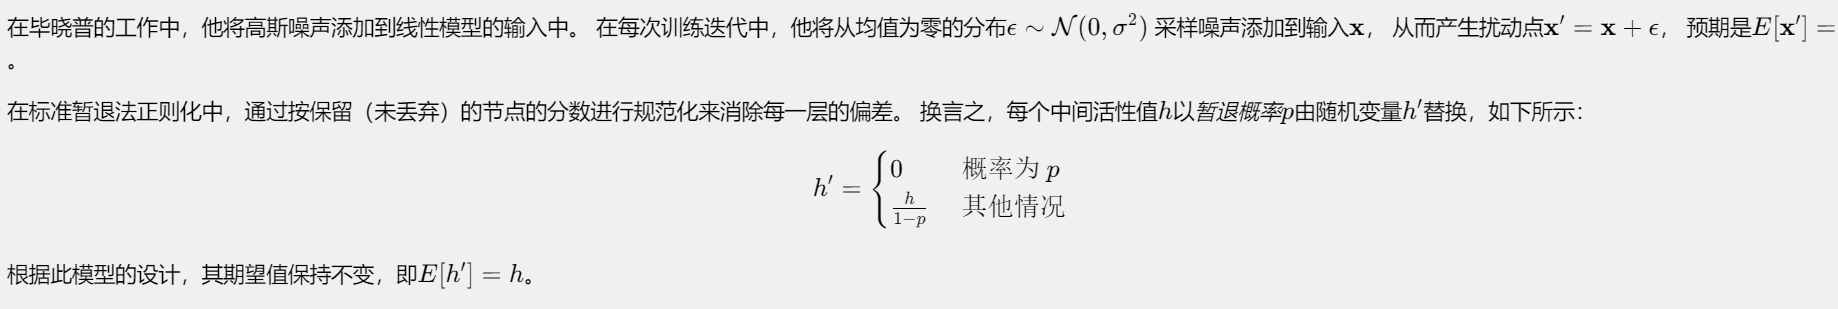

## 实践中的暂退法
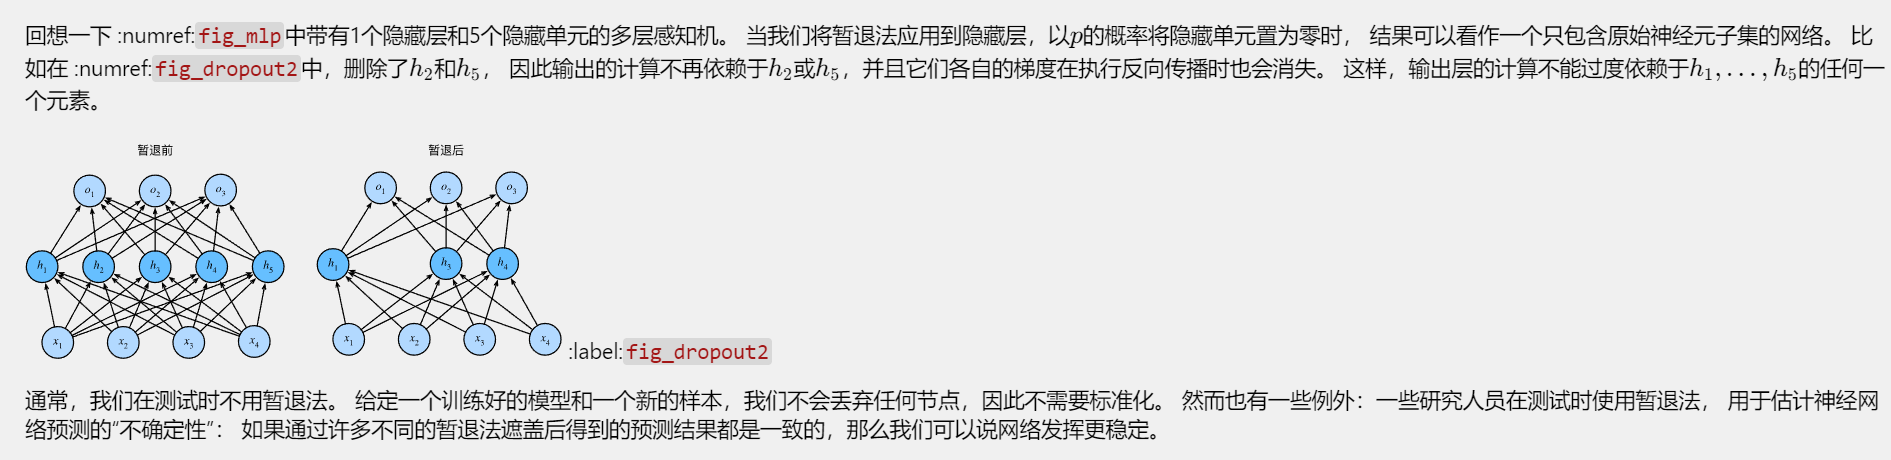

## 从零开始实现
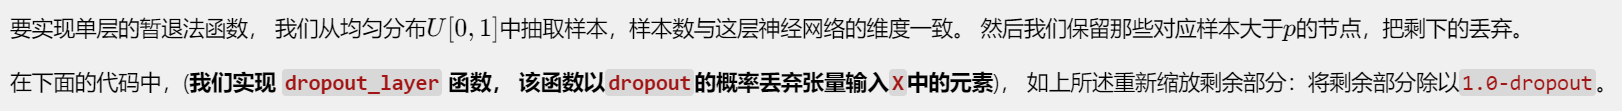

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中所有元素都会被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有的元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

下面通过几个例子来测试`dropout_layer`函数。我们将输入`X`通过暂退法操作，暂退概率分别为0, 0.5和1。

In [3]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  0.,  0.,  0., 10., 12.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 定义模型参数
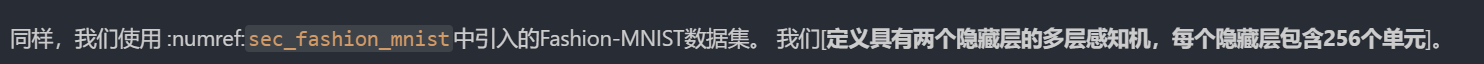

In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型结构

我们可以将暂退法应用于每个隐藏层的输出(在激活函数之后), 并且可以为每一层分别设置暂退概率：常见的技巧是在靠近输入层的地方设置较低的暂退概率。下面的模型将第一个和第二个隐藏层的暂退概率分别设置成0.2和0.5，并且暂退法侄子训练期间有效。

In [5]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        # 只有在训练模型的时候操使用dropourt
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True)

### 训练和测试
这类似与前面描述的多层感知机训练和测试。

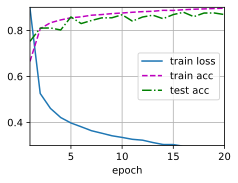

In [6]:
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现
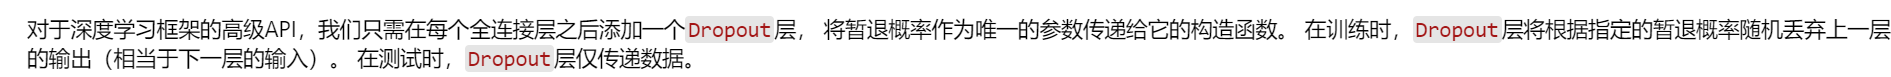

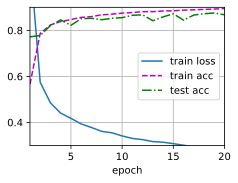

In [7]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)


trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


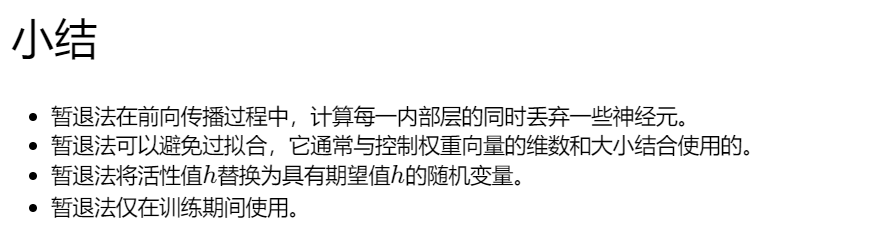